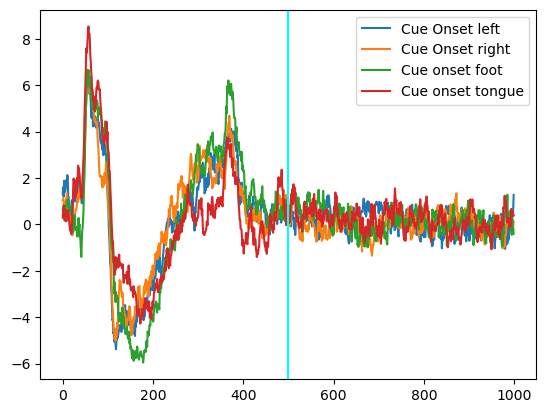

In [1]:
from keras.layers.reshaping.flatten import Flatten
from keras.layers.core.activation import Activation
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [2]:
def data_prep(X,y,sub_sample,average,noise,period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_reshape = X.reshape(X.shape[0], X.shape[1], -1, sub_sample)
    X_max = np.max(X_reshape, axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    if noise:
      X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y
        
def data_finalize(period, total_number, takeout_sample, y_test=y_test): 
    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)  # get 375 out of 2115 samples and no repetitation
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid)))) # a set(unordered) different with another set, set = set1 - set2

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period=period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period=period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period=period)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return x_train, x_valid, x_test, y_train, y_valid, y_test



X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,noise=True, period=500)


# **Train the model on subject 1 data only and test it on both subject 1 test set and all subject test set**

In [3]:
# get subject 1 data for training and validation set
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

In [4]:
print(X_train_valid.shape)


(237, 22, 1000)


In [5]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [6]:
period_accuracy={}
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)
# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]

model_sub1 = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
model_sub1.summary()

  

model_sub1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
model_sub1_results = model_sub1.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

val_acc = model_sub1_results.history['val_accuracy'][2]
period_accuracy['Sub1'] = val_acc
print(period_accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 250, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 250, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 1, 50)        12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 1, 50)       0

In [7]:
cnn_score = model_sub1.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.41999998688697815


In [ ]:
# cnn_score = model_sub1.evaluate(x_test, y_test, verbose=0)
# print('Test accuracy of the basic CNN model:',cnn_score[1])

In [16]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [22]:
period_accuracy={}
for i in range(1000, 1100, 100):
  x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)

  model_all_subs = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), 
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
  model_all_subs.summary()

  

  model_all_subs.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
  model_all_subs_results = model_all_subs.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

  val_acc = model_all_subs_results.history['val_accuracy'][1]
  period_accuracy[str(i)] = val_acc
print(period_accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 250, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 250, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 250, 1, 25)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 250, 1, 50)        12550     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 125, 1, 50)      

IndexError: list index out of range

In [23]:
cnn_score = model_all_subs.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])
print(X_test_sub1.shape)
print(y_test_sub1.shape)

Test accuracy of the basic CNN model: 0.3799999952316284
(50, 500, 1, 22)
(50, 4)


In [24]:
print(x_test.shape)
print(y_test.shape)
cnn_score = model_all_subs.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

(1772, 500, 1, 22)
(1772, 16, 4)


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "D:\Anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\Anaconda\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Anaconda\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\haora\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\haora\AppData\Local\Temp\ipykernel_16952\3657897473.py", line 3, in <module>
      cnn_score = model_all_subs.evaluate(x_test, y_test, verbose=0)
    File "D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "D:\Anaconda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\Anaconda\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "D:\Anaconda\lib\site-packages\keras\losses.py", line 277, in call
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "D:\Anaconda\lib\site-packages\keras\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions
      y_true, y_pred = tf.cond(
    File "D:\Anaconda\lib\site-packages\keras\utils\losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "D:\Anaconda\lib\site-packages\keras\utils\losses_utils.py", line 155, in remove_squeezable_dimensions
      labels = tf.cond(
    File "D:\Anaconda\lib\site-packages\keras\utils\losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze'
Can not squeeze dim[2], expected a dimension of 1, got 4
	 [[{{node categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze}}, {{node cond/remove_squeezable_dimensions/cond/Squeeze}}]] [Op:__inference_test_function_30440]

In [29]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [30]:
short_time_train_scores = {}
short_time_test_scores = {}
for i in range(50, 450, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 25, 1, 25)         5525      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 13, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 13, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 13, 1, 25)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 1, 50)         12550     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 7, 1, 50)       

 max_pooling2d_38 (MaxPoolin  (None, 10, 1, 100)       0         
 g2D)                                                            
                                                                 
 batch_normalization_38 (Bat  (None, 10, 1, 100)       400       
 chNormalization)                                                
                                                                 
 dropout_38 (Dropout)        (None, 10, 1, 100)        0         
                                                                 
 flatten_12 (Flatten)        (None, 1000)              0         
                                                                 
 dense_12 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 72,879
Trainable params: 72,529
Non-trainable params: 350
_________________________________________________________________
Epoch 1/3
218/218 [==============================] - 6s 23ms/step - lo

 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 150, 1, 25)        5525      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 75, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 75, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 75, 1, 25)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 75, 1, 50)         12550     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 38, 1, 50)        0         
 g2D)                                                            
          

In [ ]:
for i in range(450, 550, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

In [23]:
long_time_train_scores = {}
long_time_test_scores = {}
for i in range(600, 1100, 100):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

  # Printing the model summary
    model.summary()

  

  model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
  model_results = model.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

    long_time_train_scores['sub1'] = model.evaluate(x_train, y_train)[1]
    long_time_test_scores['sub1'] = model.evaluate(X_test_sub1, y_test_sub1)[1]
print(long_time_train_scores)
print(long_time_test_scores)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 38)